### Project Title: EDM Song Genre Classification 
Team member: Dayun Piao, Tien Nguyen

In [1]:
# Setup PySpark in Colab
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://archive.apache.org/dist/spark/spark-3.0.3/spark-3.0.3-bin-hadoop3.2.tgz
!tar xvf spark-3.0.3-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark==3.0.3
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.0.3-bin-hadoop3.2"

--2022-03-06 19:50:21--  https://archive.apache.org/dist/spark/spark-3.0.3/spark-3.0.3-bin-hadoop3.2.tgz
Resolving archive.apache.org (archive.apache.org)... 138.201.131.134, 2a01:4f8:172:2ec5::2
Connecting to archive.apache.org (archive.apache.org)|138.201.131.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 224762914 (214M) [application/x-gzip]
Saving to: ‘spark-3.0.3-bin-hadoop3.2.tgz’

spark-3.0.3-bin-had 100%[===================>] 214.35M   100MB/s    in 2.1s    

2022-03-06 19:50:23 (100 MB/s) - ‘spark-3.0.3-bin-hadoop3.2.tgz’ saved [224762914/224762914]

spark-3.0.3-bin-hadoop3.2/
spark-3.0.3-bin-hadoop3.2/NOTICE
spark-3.0.3-bin-hadoop3.2/kubernetes/
spark-3.0.3-bin-hadoop3.2/kubernetes/tests/
spark-3.0.3-bin-hadoop3.2/kubernetes/tests/worker_memory_check.py
spark-3.0.3-bin-hadoop3.2/kubernetes/tests/py_container_checks.py
spark-3.0.3-bin-hadoop3.2/kubernetes/tests/pyfiles.py
spark-3.0.3-bin-hadoop3.2/kubernetes/dockerfiles/
spark-3.0.3-bin-hadoop3.2

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Create a Spark session
from pyspark.sql import SparkSession
APP_NAME = "PROJECT"
spark = SparkSession.builder.appName(APP_NAME).getOrCreate()

In [4]:
# Import libraries
import pandas as pd
from matplotlib import pyplot as plt
from pyspark.ml.feature import VectorAssembler


In [5]:
# Read in edm_songs.csv as a spark dataframe
df = spark.read.csv('/content/drive/MyDrive/DSCI632/Project/edm_songs.csv',header=True, inferSchema = True)
df.show(20, truncate = False)

+---+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+----------------------+------------------------------------+--------------------------------------------------------+----------------------------------------------------------------+-----------+--------------+---------+--------------------------------+
|_c0|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo  |type          |id                    |uri                                 |track_href                                              |analysis_url                                                    |duration_ms|time_signature|genre    |title                           |
+---+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+----------------------+------------------------------------+--------------------------------------------------------+--

In [6]:
# Select features and response
potential_features_response = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'genre']
df_pot_feat_resp = df.select(potential_features_response)
df_pot_feat_resp.count()

21000

In [7]:
# Drop any missing values
df_ = df_pot_feat_resp.na.drop()
df_.count()

21000

No missing values in the data

In [8]:
df_.printSchema()

root
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- time_signature: integer (nullable = true)
 |-- genre: string (nullable = true)



In [9]:
df_.describe().show()

+-------+-------------------+-------------------+-----------------+------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+-----+
|summary|       danceability|             energy|              key|          loudness|               mode|        speechiness|        acousticness|   instrumentalness|           liveness|            valence|             tempo|       duration_ms|     time_signature|genre|
+-------+-------------------+-------------------+-----------------+------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+-----+
|  count|              21000|              21000|            21000|             21000|              21000|              21000|               21000|              21000|              210

In [10]:
# Check if responses are balanced
df_.groupBy('genre').count().show()

+---------+-----+
|    genre|count|
+---------+-----+
|hardstyle| 3000|
|     trap| 3000|
|   techno| 3000|
|psytrance| 3000|
|techhouse| 3000|
|      dnb| 3000|
|   trance| 3000|
+---------+-----+



The genre responses are even with 3000 data entries for each, data set is balanced

In [11]:
# EDA to know better the dataset

In [11]:
list_of_features = df_.columns[:-1]
list_of_labels = [x.genre for x in df_.select("genre").distinct().collect() ]

In [13]:
def plot_hist(feature, labels , df_pd):
  for label in labels:
    df_label = df_pd[feature].loc[df_pd['genre']==label]
    plt.hist(df_label, alpha = 0.6, bins = 40, label = label)
  plt.grid(b = True)
  plt.legend(loc = 'upper right')
  plt.title(feature)
  plt.xlabel(feature)
  plt.ylabel('Count')
  plt.show()

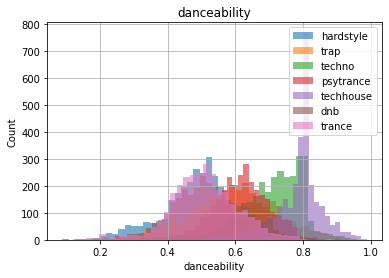

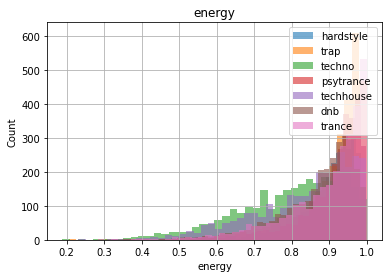

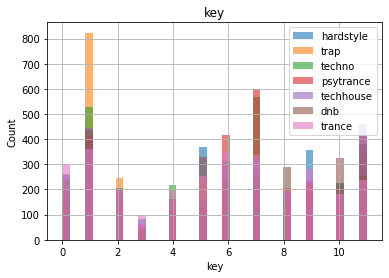

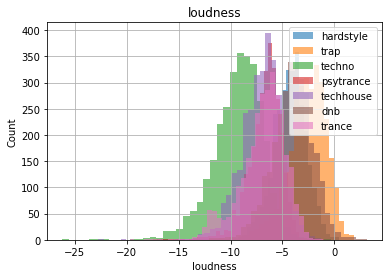

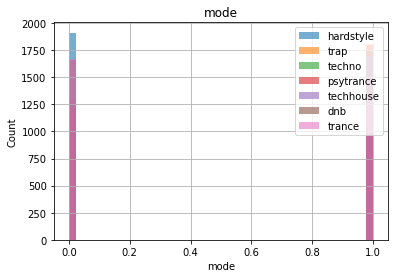

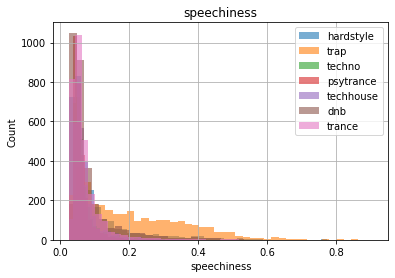

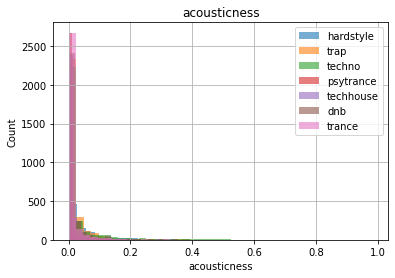

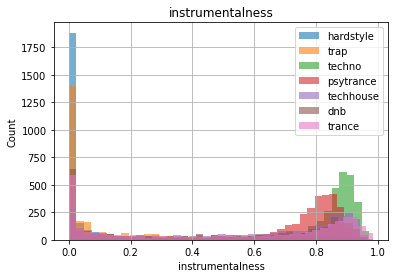

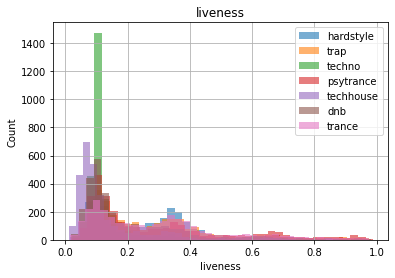

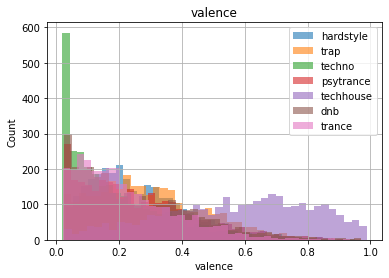

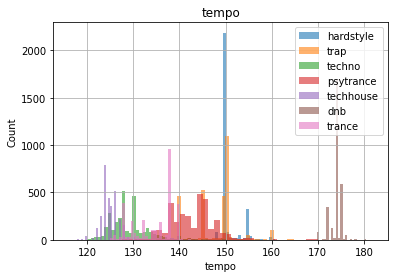

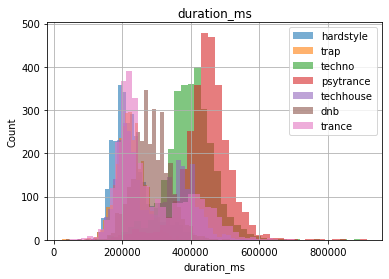

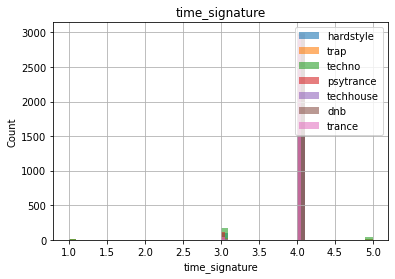

In [14]:
# plot each features distribution for each label
for feature in list_of_features:
  plot_hist(feature, list_of_labels, df_.select([feature, 'genre']).toPandas())


In [15]:
# Final selected features based on EDA, and label"genre"
features_label = ['loudness','tempo', 'duration_ms', 'danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence',  'genre']
df_features_label = df_.select(features_label)
# df_y = df.select("genre")

In [16]:
df_features_label.show()

+--------+-------+-----------+------------+------+-----------+------------+----------------+--------+-------+---------+
|loudness|  tempo|duration_ms|danceability|energy|speechiness|acousticness|instrumentalness|liveness|valence|    genre|
+--------+-------+-----------+------------+------+-----------+------------+----------------+--------+-------+---------+
|  -6.782|127.997|     197499|       0.806|  0.95|     0.0811|     9.57E-4|            0.92|   0.113|   0.58|techhouse|
|  -9.479|126.008|     507998|       0.803| 0.697|     0.0599|      1.3E-4|           0.888|   0.356|   0.35|techhouse|
|  -6.645|124.994|     206000|       0.729| 0.978|      0.042|      0.0623|           0.908|  0.0353|  0.778|techhouse|
|  -8.555|124.006|     199839|       0.724| 0.792|     0.0405|      0.0191|           0.812|   0.108|  0.346|techhouse|
|  -6.099|125.031|     173861|         0.7| 0.898|      0.257|       0.053|           0.418|   0.574|  0.791|techhouse|
|  -8.667|127.029|     394960|       0.8

In [17]:
df_features_label.describe().show()

+-------+------------------+------------------+------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-----+
|summary|          loudness|             tempo|       duration_ms|       danceability|             energy|        speechiness|        acousticness|   instrumentalness|           liveness|            valence|genre|
+-------+------------------+------------------+------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-----+
|  count|             21000|             21000|             21000|              21000|              21000|              21000|               21000|              21000|              21000|              21000|21000|
|   mean|-5.869760619047621|143.43135785714355| 309236.5250952381|          0.6024792| 0.8716178571428513|0.09381129523809496|0.0227716972623808

Based on data describe, need to scale loudness, tempo and duration to a scale between 0 and 1. Also convert genre column value to number.

In [18]:
# Data preprocessing, scale all the features between 0 and 1
from pyspark.ml.feature import MinMaxScaler

assembler = VectorAssembler().setInputCols(['loudness', 'tempo','duration_ms']).setOutputCol('assembler_features')
assembler_features = assembler.transform(df_features_label)
minMaxScaler = MinMaxScaler().setMin(0).setMax(1).setInputCol('assembler_features').setOutputCol('scaled_features')
df_scaled= minMaxScaler.fit(assembler_features).transform(assembler_features)
df_scaled.show(5)

+--------+-------+-----------+------------+------+-----------+------------+----------------+--------+-------+---------+--------------------+--------------------+
|loudness|  tempo|duration_ms|danceability|energy|speechiness|acousticness|instrumentalness|liveness|valence|    genre|  assembler_features|     scaled_features|
+--------+-------+-----------+------------+------+-----------+------------+----------------+--------+-------+---------+--------------------+--------------------+
|  -6.782|127.997|     197499|       0.806|  0.95|     0.0811|     9.57E-4|            0.92|   0.113|   0.58|techhouse|[-6.782,127.997,1...|[0.66222677595628...|
|  -9.479|126.008|     507998|       0.803| 0.697|     0.0599|      1.3E-4|           0.888|   0.356|   0.35|techhouse|[-9.479,126.008,5...|[0.57011612021857...|
|  -6.645|124.994|     206000|       0.729| 0.978|      0.042|      0.0623|           0.908|  0.0353|  0.778|techhouse|[-6.645,124.994,2...|[0.66690573770491...|
|  -8.555|124.006|     19983

In [19]:
# Show unique values of label column
label_counts = df_features_label.select("genre").distinct().count()

There are total 7 different labels

Data preprocessing, ensemble features through Vector Assembler

In [20]:
features_cols = ['scaled_features','danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']
assembler = VectorAssembler(inputCols=features_cols, outputCol='features')
df_features_label_VA = assembler.transform(df_scaled)
df_features_label_VA.show(5)

+--------+-------+-----------+------------+------+-----------+------------+----------------+--------+-------+---------+--------------------+--------------------+--------------------+
|loudness|  tempo|duration_ms|danceability|energy|speechiness|acousticness|instrumentalness|liveness|valence|    genre|  assembler_features|     scaled_features|            features|
+--------+-------+-----------+------------+------+-----------+------------+----------------+--------+-------+---------+--------------------+--------------------+--------------------+
|  -6.782|127.997|     197499|       0.806|  0.95|     0.0811|     9.57E-4|            0.92|   0.113|   0.58|techhouse|[-6.782,127.997,1...|[0.66222677595628...|[0.66222677595628...|
|  -9.479|126.008|     507998|       0.803| 0.697|     0.0599|      1.3E-4|           0.888|   0.356|   0.35|techhouse|[-9.479,126.008,5...|[0.57011612021857...|[0.57011612021857...|
|  -6.645|124.994|     206000|       0.729| 0.978|      0.042|      0.0623|          

Convert label from categorical values to numbers

In [21]:
from pyspark.ml.feature import StringIndexer
df_features_label_VA_SI = StringIndexer(inputCol = "genre", outputCol = "label").fit(df_features_label_VA).transform(df_features_label_VA)
df_features_label_VA_SI.show(5)

+--------+-------+-----------+------------+------+-----------+------------+----------------+--------+-------+---------+--------------------+--------------------+--------------------+-----+
|loudness|  tempo|duration_ms|danceability|energy|speechiness|acousticness|instrumentalness|liveness|valence|    genre|  assembler_features|     scaled_features|            features|label|
+--------+-------+-----------+------------+------+-----------+------------+----------------+--------+-------+---------+--------------------+--------------------+--------------------+-----+
|  -6.782|127.997|     197499|       0.806|  0.95|     0.0811|     9.57E-4|            0.92|   0.113|   0.58|techhouse|[-6.782,127.997,1...|[0.66222677595628...|[0.66222677595628...|  3.0|
|  -9.479|126.008|     507998|       0.803| 0.697|     0.0599|      1.3E-4|           0.888|   0.356|   0.35|techhouse|[-9.479,126.008,5...|[0.57011612021857...|[0.57011612021857...|  3.0|
|  -6.645|124.994|     206000|       0.729| 0.978|     

Get how labels are encoded from genre. Store the relationship in a dictionary to map from one to another

In [22]:
label_lst = df_features_label_VA_SI.select("label", "genre").rdd.map(tuple).collect()
label_pair_lst = list(set(label_lst))

In [23]:
label_idx = {pair[0]:pair[1] for pair in label_pair_lst}

In [24]:
df_clean = df_features_label_VA_SI.select("features", 'label')
df_clean.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.66222677595628...|  3.0|
|[0.57011612021857...|  3.0|
|[0.66690573770491...|  3.0|
|[0.60167349726775...|  3.0|
|[0.68555327868852...|  3.0|
+--------------------+-----+
only showing top 5 rows



Alternate way: Data preprocessing pipeline

In [25]:
from pyspark.ml import Pipeline

cols = ["genre"]
features_cols = ['scaled_features','danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']

stages = [StringIndexer(inputCol=col,outputCol="label").fit(df) for col in cols]
stages.append(VectorAssembler(inputCols=['loudness', 'tempo','duration_ms'],outputCol="assembler_features"))
stages.append(MinMaxScaler(min=0, max=1,inputCol=("assembler_features"), outputCol="scaled_features"))
stages.append(VectorAssembler(inputCols=features_cols,outputCol="features"))

pipeline = Pipeline(stages=stages)
df_clean2 = pipeline.fit(df_features_label).transform(df_features_label).select("features", 'label')
df_clean2.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.66222677595628...|  3.0|
|[0.57011612021857...|  3.0|
|[0.66690573770491...|  3.0|
|[0.60167349726775...|  3.0|
|[0.68555327868852...|  3.0|
+--------------------+-----+
only showing top 5 rows



In [26]:
# Split data to 8 : 2 ratio of training and testing data
train_data, test_data = df_clean.randomSplit([0.8, 0.2], seed = 1)

**Random Forest**

In [47]:
# Fit and predict on RF model
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label").fit(train_data)
rf_pred = rf.transform(test_data)
rf_pred.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[0.15075136612021...|  4.0|[0.01734731057098...|[8.67365528549090...|       4.0|
|[0.27230191256830...|  4.0|[0.05092385196362...|[0.00254619259818...|       3.0|
|[0.28210382513661...|  4.0|[0.01955351053906...|[9.77675526953195...|       4.0|
|[0.28306010928961...|  4.0|[0.00528700906344...|[2.64350453172205...|       4.0|
|[0.28944672131147...|  4.0|[0.04147121958975...|[0.00207356097948...|       4.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [28]:
from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sns
import statistics as s
import numpy as np

def evaluation(pred, modelName):
  '''
  pred: prediction PySpark dataFrame from model
  return: a series of multiclass evaluation metrics 
          computed from avg measures of each labels
  '''
  prediction_rdd = pred.select("prediction", "label").rdd.map(tuple)  
  metrics = MulticlassMetrics(prediction_rdd)
  # average precision for each label as model's precision
  precision = s.mean([ metrics.precision(i) for i in range(label_counts)])
  # same for recall
  recall = s.mean([ metrics.recall(i) for i in range(label_counts)])
  # # same for F1
  f1 = s.mean([ metrics.fMeasure(float(i),1.0) for i in range(label_counts)])

  print(f'Summary Stats: {modelName}')
  print(f'Accuracy: {metrics.accuracy:.2f}')
  print(f'Precision: {precision:.2f}')
  print(f'Recall: {recall:.2f}')
  print(f'F1 Measure: {f1:.2f}')  
  print('Confusion Matrix')
  conf_mat = metrics.confusionMatrix().toArray()

  # Convert np matrix to pandas dataframe and decode label number to original string
  label_in_order = [label_idx[i] for i in range(7)]
  df_cm = pd.DataFrame(conf_mat, index=label_in_order,columns=label_in_order)

  sns.heatmap(df_cm, cmap="Oranges", linewidths = 0.4, annot = True)

Summary Stats: Random Forest
Accuracy: 0.83
Precision: 0.84
Recall: 0.84
F1 Measure: 0.83
Confusion Matrix


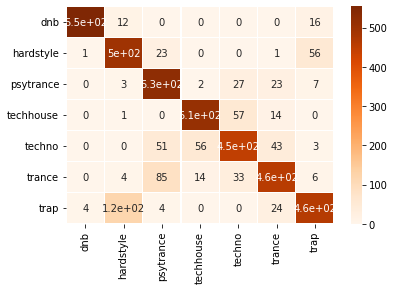

In [29]:
evaluation(rf_pred, 'Random Forest')

**Logistic Regression**

In [30]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=5)
lr_pred = lr.fit(train_data).transform(test_data)
lr_pred.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[0.15075136612021...|  4.0|[-3.3069477880172...|[5.45470823473129...|       4.0|
|[0.27230191256830...|  4.0|[-3.0269077772730...|[4.24991535024452...|       3.0|
|[0.28210382513661...|  4.0|[-2.9911894769813...|[1.06968107913964...|       4.0|
|[0.28306010928961...|  4.0|[-3.8428481993730...|[5.84280444995924...|       4.0|
|[0.28944672131147...|  4.0|[-3.3064804295226...|[5.23707248719916...|       4.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



Summary Stats: Logistic Regression
Accuracy: 0.69
Precision: 0.72
Recall: 0.69
F1 Measure: 0.68
Confusion Matrix


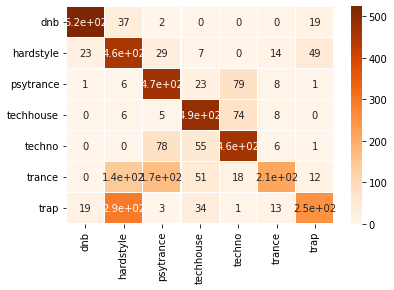

In [31]:
evaluation(lr_pred, 'Logistic Regression')

### **One-VS-All Classifier**

In [32]:
from pyspark.ml.classification import OneVsRest
ovr_lr = OneVsRest(classifier = lr)
ovrModel_lr = ovr_lr.fit(train_data)
ovr_lr_pred = ovrModel_lr.transform(test_data)
ovr_lr_pred.show(5)

+--------------------+-----+--------------------+----------+
|            features|label|       rawPrediction|prediction|
+--------------------+-----+--------------------+----------+
|[0.15075136612021...|  4.0|[-5.2985147684868...|       4.0|
|[0.27230191256830...|  4.0|[-6.2564228961325...|       3.0|
|[0.28210382513661...|  4.0|[-7.2106485164508...|       4.0|
|[0.28306010928961...|  4.0|[-7.1213108996364...|       4.0|
|[0.28944672131147...|  4.0|[-5.3438356440509...|       4.0|
+--------------------+-----+--------------------+----------+
only showing top 5 rows



Summary Stats: One Vs All - Logistic Regression
Accuracy: 0.75
Precision: 0.75
Recall: 0.75
F1 Measure: 0.75
Confusion Matrix


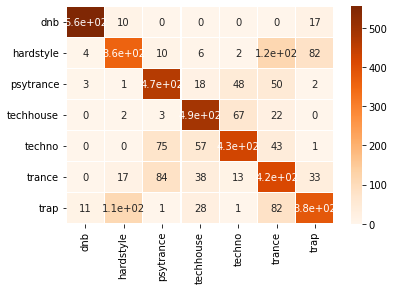

In [33]:
evaluation(ovr_lr_pred, 'One Vs All - Logistic Regression')

## **Naive Bayes**



In [34]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

nb = NaiveBayes(modelType = 'multinomial')
nbmodel = nb.fit(train_data)
nb_pred = nbmodel.transform(test_data)

nb_pred.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[0.15075136612021...|  4.0|[-9.0215462143421...|[0.11322976867768...|       4.0|
|[0.27230191256830...|  4.0|[-9.5222845358068...|[0.11375124513202...|       3.0|
|[0.28210382513661...|  4.0|[-11.398957838038...|[0.11430852321040...|       4.0|
|[0.28306010928961...|  4.0|[-11.691901333288...|[0.10260048483666...|       4.0|
|[0.28944672131147...|  4.0|[-13.793728093178...|[0.11266191510342...|       4.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



Summary Stats: Naive Bayes
Accuracy: 0.61
Precision: 0.64
Recall: 0.61
F1 Measure: 0.61
Confusion Matrix


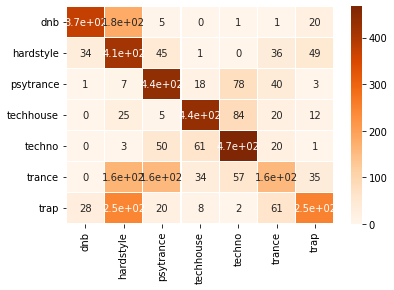

In [35]:
evaluation(nb_pred, 'Naive Bayes')

### Class prediction error plots for each model

In [36]:
#ROC is not availabel for multilabel classification in PySpark
# I'm trying to make class prediction error bar like this article but hasn't been succeed yet https://medium.com/apprentice-journal/evaluating-multi-class-classifiers-12b2946e755b

In [51]:
def plot_class_prediction_error(df, modelName):
  """
  For each actual class, plots predicted error by classes.
  """
  listOfLabels = [x.label for x in df.select("label").distinct().collect()]
  list_hist = []
  
  for label in listOfLabels:
    df_ = df.filter(df.label == label).select('label', 'prediction')

    histogram = df_.groupBy('prediction').count().collect() # Group by prediction to show the error counts
    # histogram_ = [(label, histogram[i][0], histogram[i][1]) for i in range(len(histogram)) if histogram[i][0] != label]
    histogram_ = [(label, histogram[i][0], histogram[i][1]) for i in range(len(histogram))]
    list_hist.append(histogram_) # This is lists of tuples nested inside a list, tuples are ex: ("actual class", "wrong predicted class", "frequency of wrong prediction")

  # Sort by actual class
  list_hist_sorted = sorted(list_hist, key=lambda x: x[0][0])
  # Flatten the list
  error_lst =[tpl for sub_lst in list_hist_sorted for tpl in sub_lst]
  # Initialize a 7x7 zeros array to fill in wrong predicted counts for each class
  arr = np.zeros((7,7))
  for label in sorted(listOfLabels):
    for i in error_lst:
      if i[0] == label:
        continue
      arr[int(i[1]), int(i[0])] = i[2]

  # Construct a pandas dataframe for easily plot, each column is a series of wrong prediction by class for one of seven actual class
  label_in_order = [label_idx[i] for i in range(7)]
  df = pd.DataFrame(arr, columns=label_in_order)
  # Add actual label at the first column to use as x axis label
  df.insert(0, "label", label_in_order)

  ax = df.plot(x='label', kind='bar', stacked=True, title=modelName)
  ax.grid(b = True)
  ax.legend(bbox_to_anchor=(1.0, 1.0))
  ax.set_xlabel('actual class')
  ax.set_ylabel('number of predicted class')
  

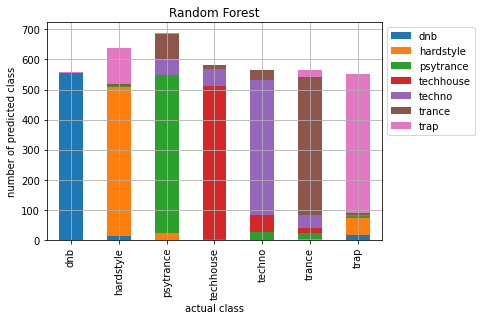

In [52]:
plot_class_prediction_error(rf_pred, 'Random Forest')

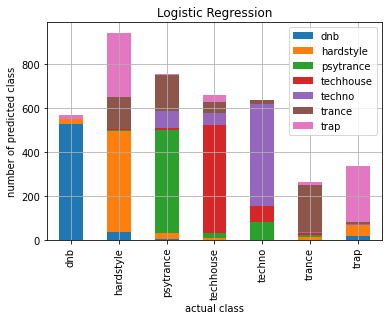

In [53]:
plot_class_prediction_error(lr_pred, 'Logistic Regression')

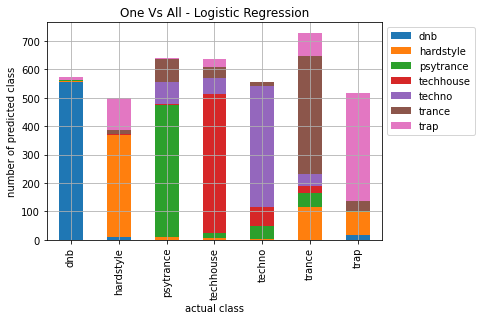

In [54]:
plot_class_prediction_error(ovr_lr_pred, 'One Vs All - Logistic Regression')

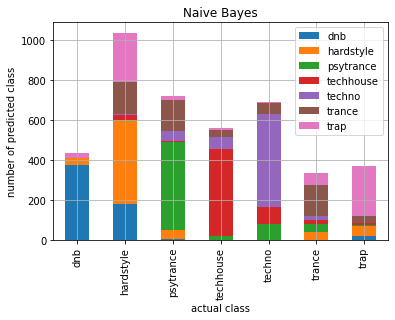

In [55]:
plot_class_prediction_error(nb_pred, 'Naive Bayes')